<a href="https://colab.research.google.com/github/AbhayMudgal/PD_prediction/blob/main/Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras as K
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("Train_set.csv")
test = pd.read_csv("Test_set.csv")
data.columns

Index(['ID', 'loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'default'],
      dtype='object')

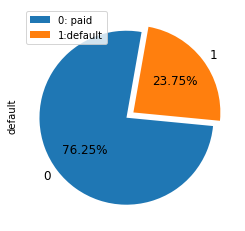

In [4]:
data.default.value_counts().plot(kind = 'pie', autopct='%1.2f%%', subplots = True, explode = (0.05, 0.05), startangle = 80, legend = True, fontsize = 12)
plt.legend(['0: paid', '1:default'])
plt.show()

In [40]:
#General Functions. Input string containing column name.
def stats(x):
    # basic statistics about a column.
    print(f"Variable: {x}")
    print(f"Type of variable: {data[x].dtype}")
    print(f"Total observations: {data[x].shape[0]}")
    detect_null_val = data[x].isnull().values.any()
    if detect_null_val:
        print(f"Missing values: {data[x].isnull().sum()} ({(data[x].isnull().sum() / data[x].isnull().shape[0] *100).round(2)}%)")
    else:
        print(f"Missing values? {data[x].isnull().values.any()}")
    print(f"Unique values: {data[x].nunique()}")
    if data[x].dtype != "O":
        print(f"Min: {int(data[x].min())}")
        print(f"25%: {int(data[x].quantile(q=[.25]).iloc[-1])}")
        print(f"Median: {int(data[x].median())}")
        print(f"75%: {int(data[x].quantile(q=[.75]).iloc[-1])}")
        print(f"Max: {int(data[x].max())}")
        print(f"Mean: {data[x].mean()}")
        print(f"Std dev: {data[x].std()}")
        print(f"Variance: {data[x].var()}")
        print(f"Skewness: {scipy.stats.skew(data[x])}")
        print(f"Kurtosis: {scipy.stats.kurtosis(data[x])}")
        print("")
        
        # Percentiles 1%, 5%, 95% and 99%print("Percentiles 1%, 5%, 95%, 99%")
        display(data[x].quantile(q=[.01, .05, .95, .99]))
        print("")
    else:
        print(f"List of unique values: {data[x].unique()}")

def segregated_counts(x):
  #plots a bar graph of the column against the unique values of default.
  zero = data[data.default == 0].loc[:, x]
  one = data[data.default == 1].loc[:, x]

  a = np.array(zero)
  b = np.array(one)

  zero.value_counts().plot(kind = 'pie', autopct='%1.2f%%', subplots = True, explode = (0.05, 0.05), startangle = 80, legend = True, fontsize = 12)
  plt.legend(['3', '5'])
  plt.title('Non-Defaults', loc = 'right')  
  plt.show()
  
  one.value_counts().plot(kind = 'pie', autopct='%1.2f%%', subplots = True, explode = (0.05, 0.05), startangle = 80, legend = True, fontsize = 12)
  plt.legend(['3', '5'])
  plt.title('Defaults', loc = 'right')  
  plt.show()

  np.warnings.filterwarnings('ignore')

  plt.hist(a, bins = 40, label = 'Non Default', align = 'left')
  plt.hist(b, bins = 40, align = 'right', label = "Default")

  plt.legend(loc = 'upper right')
  plt.title(x, loc = 'right')
  plt.xlabel('relative frequency')
  plt.ylabel('absolute frequency')
  plt.show()

def boxhist(x):
  # plots the boxplot + histogram of the data column
  column = data[x]

  mean = np.array(column).mean()
  median = np.median(column)

  f, (box, hist) = plt.subplots(2, sharex = True, gridspec_kw={"height_ratios": (0.5, 2)})

  sns.boxplot(column, ax = box)
  box.axvline(mean, color = 'r', linestyle = "--")
  box.axvline(median, color = 'g', linestyle = '-')

  sns.histplot(column, ax = hist)
  hist.axvline(mean, color = 'r', linestyle = "--")
  hist.axvline(median, color = 'g', linestyle = '-')

  plt.title(x, loc = 'right')
  plt.legend({'Mean':mean, 'Median': median})
  plt.xlabel("")
  plt.show()





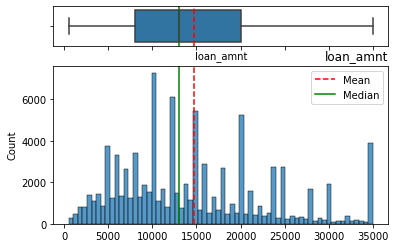

In [41]:
boxhist("loan_amnt")

In [ ]:
data['total_current_balance'].fillna(110000, inplace = True)
test['total_current_balance'].fillna(110000, inplace = True)
data['last_week_pay'].fillna(48, inplace = True)
test['last_week_pay'].fillna(48, inplace = True)
data['total_revolving_limit'].fillna(32000, inplace = True)
test['total_revolving_limit'].fillna(32000, inplace = True)
data['job_experience'].fillna(method = 'ffill', inplace = True)
test['job_experience'].fillna(method = 'ffill', inplace = True)

In [ ]:
data.dropna(inplace=True)
test.fillna(method = 'ffill', inplace = True)

In [ ]:
print(data.isna().sum().sum(), test.isna().sum().sum())

0 0


In [ ]:
data.corrwith(data.default)

loan_amnt               -0.093641
loan_term               -0.130854
interest_rate           -0.000167
job_experience          -0.029987
annual_income           -0.003020
debt_to_income          -0.132733
delinq_2yrs             -0.040749
public_records          -0.050409
revolving_balance       -0.033974
total_acc                0.000561
interest_receive         0.041382
last_week_pay            0.266158
total_current_balance   -0.001822
total_revolving_limit   -0.009536
default                  1.000000
dtype: float64

In [ ]:
le = LabelEncoder()

In [ ]:
le.fit(data.loan_grade)
data.loan_grade = le.transform(data.loan_grade)
test.loan_grade = le.transform(test.loan_grade)

In [ ]:
le.fit(data.loan_subgrade)
data.loan_subgrade = le.transform(data.loan_subgrade)
test.loan_subgrade = le.transform(test.loan_subgrade)

In [ ]:
le.fit(data.home_ownership)
data.home_ownership = le.transform(data.home_ownership)
test.home_ownership = le.transform(test.home_ownership)

In [ ]:
le.fit(data.loan_purpose)
data.loan_purpose = le.transform(data.loan_purpose)
test.loan_purpose = le.transform(test.loan_purpose)

In [ ]:
le.fit(data.income_verification_status)
data.income_verification_status = le.transform(data.income_verification_status)
test.income_verification_status = le.transform(test.income_verification_status)

In [ ]:
data.head(15)

,loan_amnt,loan_term,interest_rate,loan_grade,loan_subgrade,job_experience,home_ownership,annual_income,income_verification_status,loan_purpose,debt_to_income,delinq_2yrs,public_records,revolving_balance,total_acc,interest_receive,last_week_pay,total_current_balance,total_revolving_limit,default
0,9000,3,9.17,1,6,2.5,3,85000.0,0,1,26.68,0.0,0.0,39519,20.0,59.60,4.0,95493.0,84100.0,0
1,18000,3,13.65,2,10,2.5,3,64000.0,2,1,31.67,0.0,1.0,9783,24.0,3348.25,95.0,185433.0,13500.0,0
2,16000,3,7.26,0,3,2.5,0,150000.0,1,1,19.70,2.0,0.0,13641,27.0,276.69,13.0,180519.0,19300.0,0
3,25000,3,13.99,2,13,2.5,0,59800.0,2,1,37.39,0.0,0.0,35020,35.0,1106.72,17.0,183208.0,55400.0,0
4,17000,3,6.39,0,1,12.5,0,72000.0,1,0,8.92,0.0,0.0,23990,26.0,725.29,39.0,23990.0,81300.0,0
5,10000,3,12.69,2,11,2.5,3,56000.0,0,1,16.16,0.0,1.0,6643,48.0,590.50,26.0,24054.0,25167.0,0
6,15000,3,11.14,1,6,12.5,4,100000.0,0,1,10.51,0.0,1.0,14088,14.0,1020.57,35.0,14519.0,15200.0,1
7,10000,3,6.49,0,1,12.5,0,109000.0,0,0,10.84,1.0,0.0,12337,26.0,728.68,74.0,210751.0,18600.0,0
8,12000,3,10.99,1,8,2.5,4,45000.0,2,0,8.21,0.0,0.0,10550,12.0,879.15,39.0,10550.0,22000.0,0
9,7000,3,12.49,1,8,2.5,0,53000.0,0,1,18.84,0.0,0.0,12108,20.0,1186.80,96.0,145801.0,16800.0,0


In [ ]:
def transform(a, b):
  mi = min(a)
  ma = max(a)

  for i in range(len(a)):
    a.iloc[i] = (a.iloc[i] - mi)/(ma - mi)

  for i in range(len(b)):
    b.iloc[i] = (b.iloc[i] - mi)/(ma - mi)

  return a, b;

In [ ]:
data.loan_amnt, test.loan_amnt = transform(data.loan_amnt, test.loan_amnt)
data.interest_rate, test.interest_rate = transform(data.interest_rate, test.interest_rate)
data.annual_income, test.annual_income = transform(data.annual_income, test.annual_income)
data.revolving_balance, test.revolving_balance = transform(data.revolving_balance, test.revolving_balance)
data.total_acc, test.total_acc = transform(data.total_acc, test.total_acc)
data.interest_receive, test.interest_receive = transform(data.interest_receive, test.interest_receive)
data.last_week_pay, test.last_week_pay = transform(data.last_week_pay, test.last_week_pay)
data.total_current_balance, test.total_current_balance = transform(data.total_current_balance, test.total_current_balance)
data.total_revolving_limit, test.total_revolving_limit = transform(data.total_revolving_limit, test.total_revolving_limit)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
data.head(15)

,loan_amnt,loan_term,interest_rate,loan_grade,loan_subgrade,job_experience,home_ownership,annual_income,income_verification_status,loan_purpose,debt_to_income,delinq_2yrs,public_records,revolving_balance,total_acc,interest_receive,last_week_pay,total_current_balance,total_revolving_limit,default
0,0.246377,3,0.162653,1,6,2.5,3,0.008822,0,1,26.68,0.0,0.0,0.015433,0.161017,0.002572,0.013746,0.011937,0.008410,0
1,0.507246,3,0.351922,2,10,2.5,3,0.006611,2,1,31.67,0.0,1.0,0.003820,0.194915,0.144494,0.326460,0.023179,0.001350,0
2,0.449275,3,0.081960,0,3,2.5,0,0.015665,1,1,19.70,2.0,0.0,0.005327,0.220339,0.011941,0.044674,0.022565,0.001930,0
3,0.710145,3,0.366286,2,13,2.5,0,0.006169,2,1,37.39,0.0,0.0,0.013676,0.288136,0.047760,0.058419,0.022901,0.005540,0
4,0.478261,3,0.045205,0,1,12.5,0,0.007454,1,0,8.92,0.0,0.0,0.009369,0.211864,0.031300,0.134021,0.002999,0.008130,0
5,0.275362,3,0.311365,2,11,2.5,3,0.005769,0,1,16.16,0.0,1.0,0.002594,0.398305,0.025483,0.089347,0.003007,0.002517,0
6,0.420290,3,0.245881,1,6,12.5,4,0.010401,0,1,10.51,0.0,1.0,0.005502,0.110169,0.044043,0.120275,0.001815,0.001520,1
7,0.275362,3,0.049430,0,1,12.5,0,0.011349,0,0,10.84,1.0,0.0,0.004818,0.211864,0.031446,0.254296,0.026344,0.001860,0
8,0.333333,3,0.239544,1,8,2.5,4,0.004611,2,0,8.21,0.0,0.0,0.004120,0.093220,0.037940,0.134021,0.001319,0.002200,0
9,0.188406,3,0.302915,1,8,2.5,0,0.005453,0,1,18.84,0.0,0.0,0.004728,0.161017,0.051216,0.329897,0.018225,0.001680,0


In [ ]:
def categorical_transform(a, array):
  sub_array = to_categorical(a)
  if len(array) == 0:
    array = sub_array
  else: 
    array = np.append(array, sub_array, axis = 1)
  return array

categorical_list = ['loan_term', 'loan_grade', 'loan_subgrade', 'job_experience', 'home_ownership', 'loan_purpose', 'income_verification_status']

data_train = []
data_test = []
for item in categorical_list:
  data_train = categorical_transform(data[item], data_train)
  data_test = categorical_transform(test[item], data_test)
  data.drop([item], axis = 1, inplace = True)
  test.drop([item], axis = 1, inplace = True)

data_train = np.array(data_train)
data_test = np.array(data_test)

KeyError: ignored

In [ ]:
print(len(data_train), len(data_test))

0 0


In [ ]:
y = data['default']
data.drop(['default', 'loan_subgrade'], axis = 1, inplace = True)
test.drop(['loan_subgrade'], axis = 1, inplace = True)

In [ ]:
print(data.shape, test.shape)

(93172, 18) (39933, 18)


In [ ]:
X = data.to_numpy()
Y = y.to_numpy()
X_test = test.to_numpy()

In [ ]:
X = np.append(X, sub, axis = 1)
X_test = np.append(X_test, sub2, axis = 1)

In [ ]:
print(X.shape, X_test.shape)

(93172, 53) (39933, 53)


In [ ]:
model = K.Sequential([
      K.layers.Dense(53, input_shape = (53,), activation='relu'),
      K.layers.Dense(64,  activation='relu'),
      K.layers.Dense(16, activation='relu'),
      K.layers.Dense(1, activation='sigmoid')                 
])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 53)                2862      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                3456      
_________________________________________________________________
dense_32 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 7,375
Trainable params: 7,375
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = K.optimizers.SGD(learning_rate = 0.1)

In [ ]:
model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['accuracy'])
history = model.fit(X, y, epochs = 25, validation_split = 0.15)

2475/2475 [==============================] - 3s 1ms/step - loss: 0.2386 - accuracy: 0.7614 - val_loss: 0.2309 - val_accuracy: 0.7691
Epoch 12/25
1210/2475 [=============>................] - ETA: 1s - loss: 0.2391 - accuracy: 0.7609

KeyboardInterrupt: ignored

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission.head(10)

0     4855329
1    66862420
2     3637416
3    53682249
4    53937165
5     1464149
6     7429943
7    10047245
8    46816125
9    57125517
Name: ID, dtype: int64

In [ ]:
sub.shape

(39933,)

In [ ]:
y_pred.shape

(39933, 1)

In [ ]:
submission.to_csv("submission.csv")

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv("y.csv")